In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import itertools

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
df_train = pd.read_csv('./train_round2/Annotations/label.csv', header=None)
df_train.columns = ['image_id', 'class', 'label']
df_train.head()

,image_id,class,label
0,Images/collar_design_labels/b23a3fe060d71bed77...,collar_design_labels,ynnnn
1,Images/collar_design_labels/0ef580b4deabcd9fa4...,collar_design_labels,ynnnn
2,Images/collar_design_labels/87ccc33937821a97ad...,collar_design_labels,nnynn
3,Images/collar_design_labels/26caac7d1f1b36fb9d...,collar_design_labels,ynnnn
4,Images/collar_design_labels/396ab4e7cbc6798100...,collar_design_labels,nynnn


In [3]:
classes = ['collar_design_labels', 'neckline_design_labels', 'skirt_length_labels',
          'sleeve_length_labels', 'neck_design_labels', 'coat_length_labels', 'lapel_design_labels',
          'pant_length_labels']

In [4]:
cur_class = classes[6]
df_load = df_train[(df_train['class'] == cur_class)].copy()
df_load.reset_index(inplace=True)
del df_load['index']

print('{0}: {1}'.format(cur_class, len(df_load)))
df_load.head()

lapel_design_labels: 8876


,image_id,class,label
0,Images/lapel_design_labels/bf1e0ae60afeafeeccf...,lapel_design_labels,nnnny
1,Images/lapel_design_labels/fa185f8c9d166793acf...,lapel_design_labels,ynnnn
2,Images/lapel_design_labels/f5d6d847c3ee7d4fc2e...,lapel_design_labels,nnnny
3,Images/lapel_design_labels/8774f7de05922f0c448...,lapel_design_labels,nnnyn
4,Images/lapel_design_labels/6612436b2c115e7acbc...,lapel_design_labels,ynnnn


### 根据混淆矩阵手动label smoothing

In [5]:
lsr = [[0.9,0,0.1,0,0],[0,0.8,0.067,0.067,0.067],[0.1,0,0.9,0,0],[0,0,0,1,0],[0,0.1,0.1,0,0.8]]

In [6]:
task = cur_class
image_path = []
for i in range(len(df_load)):
    image_path.append(('./train_round2/' + df_load['image_id'][i], df_load['label'][i]))
n_class = len(df_load['label'][0])
width = 299 # 定义图片大小

In [7]:
from PIL import Image
import os
import os.path
from skimage import data, img_as_float
from skimage import exposure
import shutil

In [8]:
import gc
%xdel X_train
%xdel y_train
%xdel X_valid
%xdel y_valid
gc.collect()

NameError: name 'X_train' is not defined
NameError: name 'y_train' is not defined
NameError: name 'X_valid' is not defined
NameError: name 'y_valid' is not defined


0

In [9]:
traindir= os.path.join('./train_round2/train_valid', task, 'trainall')
n_train = sum([len(x) for _, _, x in os.walk(traindir)])
#n_train = 15977
print (n_train)

31956


In [10]:
valdir= os.path.join('./train_round2/train_valid', task, 'valall')
n_val = sum([len(x) for _, _, x in os.walk(valdir)])
print (n_val)

887


In [11]:
width = 299 # 定义图片大小

X_train = np.zeros((n_train, width, width, 3), dtype=np.uint8)
y_train = np.zeros((n_train, n_class), dtype=np.float32)
X_valid = np.zeros((n_val, width, width, 3), dtype=np.uint8)
y_valid = np.zeros((n_val, n_class), dtype=np.float32)

In [12]:
count = 0
train_image_path = []
for parent, dirnames, filenames in os.walk(traindir):
    for filename in filenames:
        if '._'not in filename and 'jpg' in filename:
            currentPath = os.path.join(parent, filename)
            train_image_path.append(currentPath)
            labelfile = parent.split('/')[-1]
            
            img = cv2.imread(currentPath)
            row, column, channels = img.shape
            if row == column:
                X_train[count] = cv2.resize(img,(width, width))
            else:
                max_value = max(row, column)
                pad_img= cv2.copyMakeBorder(img,(max_value-row)//2,(max_value-row)//2,(max_value-column)//2,(max_value-column)//2,cv2.BORDER_CONSTANT)
                X_train[count] = cv2.resize(pad_img, (width, width), interpolation=cv2.INTER_AREA)
        
            y_train[count]=lsr[int(labelfile)]  #label smoothing
            #y_train[count][int(labelfile)]=1
            count += 1
print(count)

31956


In [13]:
#valdir= os.path.join('./train_round2/train_valid', task, 'val4')

In [14]:
count = 0
vaild_image_path= []
for parent, dirnames, filenames in os.walk(valdir):
    for filename in filenames:
        if 'jpg' in filename:
            currentPath = os.path.join(parent, filename)
            vaild_image_path.append(currentPath)
            labelfile = parent.split('/')[-1]
            
            img = cv2.imread(currentPath)
            row, column, channels = img.shape
            if row == column:
                X_valid[count] = cv2.resize(img,(width, width))
            else:
                max_value = max(row, column)
                pad_img= cv2.copyMakeBorder(img,(max_value-row)//2,(max_value-row)//2,(max_value-column)//2,(max_value-column)//2,cv2.BORDER_CONSTANT)
                X_valid[count] = cv2.resize(pad_img, (width, width), interpolation=cv2.INTER_AREA)
                
            #y_valid[count][int(labelfile)]=1
            y_valid[count]=lsr[int(labelfile)]  #label smoothing
            count += 1
print(count)

887


## 搭建模型

In [17]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras.optimizers import *
from keras.applications import *
from keras.regularizers import *
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import RMSprop
import keras
import gc

#from keras.applications.resnet50 import preprocess_input,ResNet50

Using TensorFlow backend.


In [18]:
cnn_model = InceptionResNetV2(include_top=False, input_shape=(width, width, 3), weights='imagenet')

In [19]:
inputs = Input((width, width, 3))

x = inputs
x = Lambda(preprocess_input, name='preprocessing')(x)
x = cnn_model(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax', name='softmax')(x)

model = Model(inputs, x)

In [20]:
prefix_cls = cur_class.split('_')[0]
prefix_cls

'lapel'

## 配置模型

In [21]:
# Compile the model
adam = Adam(lr=0.001) 
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 1
batch_size = 64

In [22]:
model.load_weights('./models/{0}.best0513_InceptionResNetV2_round1.h5'.format(prefix_cls)) #加载初赛训练好的模型，继续测试

## 模型训练

In [23]:
checkpointer = ModelCheckpoint(filepath='./models/{0}.best0524_InceptionResNetV2_round2.h5'.format(prefix_cls), verbose=1, 
                               save_best_only=True)

h = model.fit(X_train, y_train, batch_size=64, epochs=epochs, 
              callbacks=[EarlyStopping(patience=3), checkpointer], 
              shuffle=True, 
              validation_data=(X_valid, y_valid))

Train on 31956 samples, validate on 887 samples
Epoch 1/1
31956/31956 [==============================] - 702s 22ms/step - loss: 0.9820 - acc: 0.7227 - val_loss: 1.0544 - val_acc: 0.6731

Epoch 00001: val_loss improved from inf to 1.05441, saving model to ./models/lapel.best0524_InceptionResNetV2_round2.h5


In [24]:
cnn_model = InceptionResNetV2(include_top=False, input_shape=(width, width, 3), weights='imagenet')

In [25]:
inputs = Input((width, width, 3))

x = inputs
x = Lambda(preprocess_input, name='preprocessing')(x)
x = cnn_model(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax', name='softmax')(x)

model = Model(inputs, x)

In [26]:
# Compile the model
adam = Adam(lr=0.00002) 

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 1
batch_size = 64

In [27]:
model.load_weights('./models/{}.best0524_InceptionResNetV2_round2.h5'.format(prefix_cls)) #加载以前训练好的模型，继续测试

In [28]:
checkpointer = ModelCheckpoint(filepath='./models/{0}.best0524_InceptionResNetV2_round2_step2.h5'.format(prefix_cls), verbose=1, 
                               save_best_only=True)

h = model.fit(X_train, y_train, batch_size=64, epochs=epochs, 
              callbacks=[EarlyStopping(patience=3), checkpointer], 
              shuffle=True, 
              validation_data=(X_valid, y_valid))

Train on 31956 samples, validate on 887 samples
Epoch 1/1
31956/31956 [==============================] - 711s 22ms/step - loss: 0.6920 - acc: 0.8960 - val_loss: 0.9402 - val_acc: 0.7790

Epoch 00001: val_loss improved from inf to 0.94023, saving model to ./models/lapel.best0524_InceptionResNetV2_round2_step2.h5


In [16]:
model.load_weights('./models/{}.best0524_InceptionResNetV2_round2_step2.h5'.format(prefix_cls)) #加载以前训练好的模型，继续测试

## 混淆矩阵

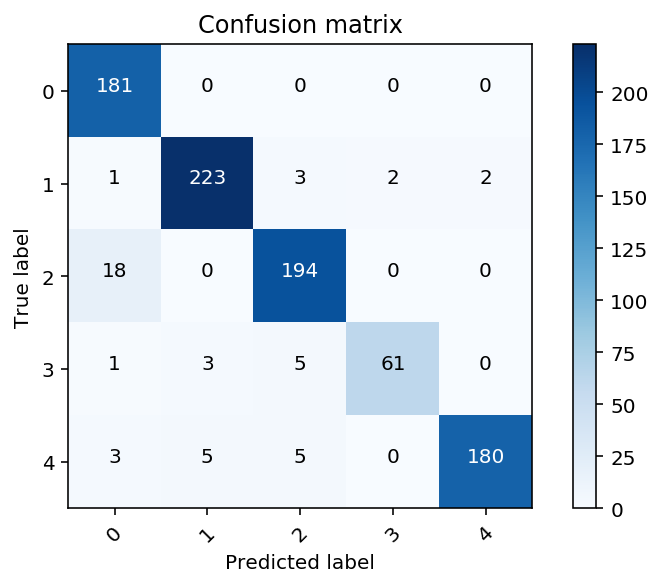

In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This fuction prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Predict the values from the validation dataset
#Y_pred = model.predict(X_valid)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_valid, axis=1)
# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plt the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(n_class))

In [22]:
confusion4to1 = []
confusion2to0 = []
confusion0to2 = []
#confusion2to3 = []
#confusion3to2 = []
for i in range(len(Y_pred_classes)):
    if (Y_true[i] == 4) and (Y_pred_classes[i] == 1):
        confusion4to1.append(i)
    elif (Y_true[i] == 2) and (Y_pred_classes[i] == 0):
        confusion2to0.append(i)
    elif (Y_true[i] == 0) and (Y_pred_classes[i] == 2):
        confusion0to2.append(i)

In [38]:
count = 0
for i in range(len(Y_pred_classes)):
    if (Y_true[i] != Y_pred_classes[i]):
        count += 1

print((len(Y_pred_classes)-count)/len(Y_pred_classes))
print(count)
print(len(Y_pred_classes))

0.7745208568207441
200
887


## TTA 

In [29]:
valdir= os.path.join('./train_round2/train_valid', task, 'val0')  #水平翻转

count = 0
vaild_image_path= []
for parent, dirnames, filenames in os.walk(valdir):
    for filename in filenames:
        if 'jpg' in filename:
            currentPath = os.path.join(parent, filename)
            vaild_image_path.append(currentPath)
            labelfile = parent.split('/')[-1]
            X_valid[count] = cv2.resize(cv2.imread(currentPath),(width, width))
            y_valid[count][int(labelfile)]=1
            count += 1
print(count)

887


In [30]:
Y_pred_0 = model.predict(X_valid)

In [31]:
valdir= os.path.join('./train_round2/train_valid', task, 'valall') # 原图

count = 0
vaild_image_path= []
for parent, dirnames, filenames in os.walk(valdir):
    for filename in filenames:
        if 'jpg' in filename:
            currentPath = os.path.join(parent, filename)
            vaild_image_path.append(currentPath)
            labelfile = parent.split('/')[-1]
            X_valid[count] = cv2.resize(cv2.imread(currentPath),(width, width))
            y_valid[count][int(labelfile)]=1
            count += 1
print(count)

887


In [32]:
Y_pred_1 = model.predict(X_valid)

In [33]:
valdir= os.path.join('./train_round2/train_valid', task, 'val1')  #直方图
count = 0
vaild_image_path= []
for parent, dirnames, filenames in os.walk(valdir):
    for filename in filenames:
        if 'jpg' in filename:
            currentPath = os.path.join(parent, filename)
            vaild_image_path.append(currentPath)
            labelfile = parent.split('/')[-1]
            X_valid[count] = cv2.resize(cv2.imread(currentPath),(width, width))
            y_valid[count][int(labelfile)]=1
            count += 1
print(count)

887


In [34]:
Y_pred_2 = model.predict(X_valid)

In [35]:
valdir= os.path.join('./train_round2/train_valid', task, 'val2') #对比度拉升
count = 0
vaild_image_path= []
for parent, dirnames, filenames in os.walk(valdir):
    for filename in filenames:
        if 'jpg' in filename:
            currentPath = os.path.join(parent, filename)
            vaild_image_path.append(currentPath)
            labelfile = parent.split('/')[-1]
            X_valid[count] = cv2.resize(cv2.imread(currentPath),(width, width))
            y_valid[count][int(labelfile)]=1
            count += 1
print(count)

887


In [36]:
Y_pred_3 = model.predict(X_valid)

In [44]:
Y_pred = (Y_pred_0+Y_pred_1+Y_pred_2+Y_pred_3)/4
Y_pred = Y_pred_3
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
count = 0
for i in range(len(Y_pred_classes)):
    if (Y_true[i] != Y_pred_classes[i]):
        count += 1

print((len(Y_pred_classes)-count)/len(Y_pred_classes))
print(count)
print(len(Y_pred_classes))

0.7666290868094702
207
887


In [27]:
#for i in confusion4to1:
#    plt.figure(figsize=(12, 7))
#    plt.subplot(1, 1, 1)
#    plt.imshow(X_valid[i][:,:,::-1])
#    ID = 'Images/lapel_design_labels/'+ vaild_image_path[i].split('val2')[-1]
#    plt.title(df_train[df_train['image_id'].isin([ID])]['label'])

## mAP计算

In [77]:
label = []
for path in vaild_image_path:
    ID = 'Images/lapel_design_labels/'+ path.split('val0')[-1]
    label.append(df_train[df_train['image_id'].isin([ID])]['label'].values[0])

In [78]:
result = []
for tmp_list in Y_pred:
    tmp_result = ''
    for tmp_ret in tmp_list:
        tmp_result += '{:.4f},'.format(tmp_ret)    
    result.append(tmp_result[:-1])    
result   

['0.0249,0.1711,0.6510,0.0076,0.1454',
 '0.3340,0.0120,0.5813,0.0271,0.0455',
 '0.1190,0.0098,0.8386,0.0024,0.0302',
 '0.1363,0.0389,0.8217,0.0022,0.0008',
 '0.0739,0.2296,0.6935,0.0007,0.0024',
 '0.1075,0.0320,0.8158,0.0356,0.0091',
 '0.1546,0.1129,0.6508,0.0190,0.0627',
 '0.0007,0.0349,0.9106,0.0075,0.0463',
 '0.5078,0.1116,0.3266,0.0031,0.0510',
 '0.2445,0.0470,0.4277,0.2428,0.0380',
 '0.0050,0.0038,0.9875,0.0016,0.0021',
 '0.2371,0.0016,0.7324,0.0014,0.0275',
 '0.0453,0.0840,0.8680,0.0020,0.0007',
 '0.1105,0.0198,0.8573,0.0062,0.0062',
 '0.0021,0.0296,0.7322,0.2290,0.0071',
 '0.0024,0.1239,0.7598,0.0131,0.1008',
 '0.0046,0.0106,0.8699,0.1010,0.0139',
 '0.2372,0.0407,0.6857,0.0060,0.0304',
 '0.1402,0.0179,0.8365,0.0029,0.0025',
 '0.1778,0.1536,0.6358,0.0208,0.0120',
 '0.2623,0.0066,0.7262,0.0029,0.0020',
 '0.0110,0.0137,0.9155,0.0042,0.0557',
 '0.0587,0.0259,0.9005,0.0089,0.0059',
 '0.0534,0.0123,0.8382,0.0031,0.0931',
 '0.0374,0.0038,0.9565,0.0014,0.0009',
 '0.2473,0.0012,0.6482,0.

In [79]:
df_map = pd.DataFrame()
df_map['label'] = label
df_map['result'] = result

In [80]:
p = 0.0
j = 0
for ProbThreshold in np.arange(0,1,0.001):   
    j = j + 1
    PRED_COUNT = 0
    BLOCK_COUNT = 0
    PRED_CORRECT_COUNT = 0

    for df_label,df_result in zip(df_map['label'][:],df_map['result'][:]):
        test_array = []
        for i in df_result.split(','):
            test_array.append(float(i))
        y_label = df_label.find('y')
        m_label = df_label.find('m')
        op_argsort = np.argsort(test_array)[::-1]
        #print(max(test_array))
        #print(op_argsort)
        #print(y_label)
        #print(m_label)
        if max(test_array) <  ProbThreshold:
            BLOCK_COUNT = BLOCK_COUNT + 1
            continue
        if op_argsort[0] == m_label:
            BLOCK_COUNT = BLOCK_COUNT + 1
            continue
        if op_argsort[0] == y_label:
            PRED_COUNT = PRED_COUNT + 1
            PRED_CORRECT_COUNT = PRED_CORRECT_COUNT + 1
        else:
            PRED_COUNT = PRED_COUNT + 1  
    p = p + PRED_CORRECT_COUNT/PRED_COUNT
    
print(p/j)

0.9792257395912876


## 测试数据TTA

In [17]:
df_test = pd.read_csv('./week-rank/Tests/question.csv', header=None)
df_test.columns = ['image_id', 'class', 'x']
del df_test['x']
df_test.head()

,image_id,class
0,Images/collar_design_labels/1078bc9a4fa91aef69...,collar_design_labels
1,Images/collar_design_labels/272c5d069581efc94f...,collar_design_labels
2,Images/collar_design_labels/2e67922d82216cc756...,collar_design_labels
3,Images/collar_design_labels/d9726ceee17c7ee811...,collar_design_labels
4,Images/collar_design_labels/1b7de7f9def99a5aa6...,collar_design_labels


In [18]:
df_load = df_test[(df_test['class'] == cur_class)].copy()
df_load.reset_index(inplace=True)
del df_load['index']

print('{0}: {1}'.format(cur_class, len(df_load)))
df_load.head()

lapel_design_labels: 1406


,image_id,class
0,Images/lapel_design_labels/4584969997a2d7dea74...,lapel_design_labels
1,Images/lapel_design_labels/cd6f068e9672d11bf74...,lapel_design_labels
2,Images/lapel_design_labels/26890cbaf789eb99f3f...,lapel_design_labels
3,Images/lapel_design_labels/056f95626aad6c39883...,lapel_design_labels
4,Images/lapel_design_labels/5883dd9d1ba746fbe44...,lapel_design_labels


In [19]:
n = len(df_load)
X_test = np.zeros((n, width, width, 3), dtype=np.uint8)

for i in tqdm(range(n)):
    X_test[i] = cv2.resize(cv2.imread('./week-rank/{0}'.format(df_load['image_id'][i])), (width, width))

100%|██████████| 1406/1406 [00:08<00:00, 163.03it/s]


In [31]:
# 原图
test_np_0 = model.predict(X_test)

In [22]:
#水平翻转
X_test_1 = np.zeros((n, width, width, 3), dtype=np.uint8)
for i in tqdm(range(n)):
    X_test_1[i] = cv2.flip(X_test[i], 1)

100%|██████████| 1406/1406 [00:00<00:00, 5336.40it/s]


In [32]:
test_np_1 = model.predict(X_test_1)

In [24]:
# 直方图均衡处理
X_test_2 = np.zeros((n, width, width, 3), dtype=np.uint8)
for i in tqdm(range(n)):
    X_test_2[i] = exposure.equalize_hist(X_test[i])*255

100%|██████████| 1406/1406 [00:11<00:00, 119.61it/s]


In [33]:
test_np_2 = model.predict(X_test_2)

In [26]:
# cs对比度拉长处理
X_test_3 = np.zeros((n, width, width, 3), dtype=np.uint8)
for i in tqdm(range(n)):
    p2, p98 = np.percentile(X_test[i], (2, 98))
    X_test_3[i] = exposure.rescale_intensity(X_test[i], in_range=(p2, p98))

100%|██████████| 1406/1406 [00:04<00:00, 349.76it/s]


In [34]:
test_np_3 = model.predict(X_test_3)

In [36]:
test_np = (test_np_0+test_np_1+test_np_2+test_np_3)/4
#test_np = test_np_1
result = []

for i, row in df_load.iterrows():
    tmp_list = test_np[i]
    tmp_result = ''
    for tmp_ret in tmp_list:
        tmp_result += '{:.4f};'.format(tmp_ret)
        
    result.append(tmp_result[:-1])

df_load['result'] = result
df_load.head()

,image_id,class,result
0,Images/lapel_design_labels/4584969997a2d7dea74...,lapel_design_labels,0.0001;0.9863;0.0090;0.0038;0.0008
1,Images/lapel_design_labels/cd6f068e9672d11bf74...,lapel_design_labels,0.0001;0.9513;0.0001;0.0385;0.0100
2,Images/lapel_design_labels/26890cbaf789eb99f3f...,lapel_design_labels,0.0000;0.0000;0.0000;0.0000;1.0000
3,Images/lapel_design_labels/056f95626aad6c39883...,lapel_design_labels,0.0510;0.0002;0.9487;0.0000;0.0000
4,Images/lapel_design_labels/5883dd9d1ba746fbe44...,lapel_design_labels,0.0012;0.8986;0.0056;0.0850;0.0097
